# Goals

# Libraries

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
import numpy as np
from scipy.stats.mstats import zscore
from factor_analyzer import FactorAnalyzer
from factor_analyzer import confirmatory_factor_analyzer
import pingouin as pg
from linearmodels import PanelOLS
from linearmodels.panel import compare as compare_models
import statsmodels.api as sm
from io import StringIO
from IPython.display import display, HTML
from scipy import stats
from numpy import dot
from numpy.linalg import norm
from adjustText import adjust_text
import seaborn as sns
import matplotlib.cm as cm

# Parameters & Directories

In [2]:
pd.set_option('mode.chained_assignment', None)
%config InlineBackend.figure_format='retina'

In [77]:
# Add system fonts to matplot
from matplotlib.font_manager import findSystemFonts
import matplotlib.font_manager as font_manager
import matplotlib as mpl
fonts = findSystemFonts()
fonts.extend(findSystemFonts(fontpaths=['./nimbus-sans-l/']))
for font in fonts:
    try:
        font_manager.fontManager.addfont(font)
    except:
        print(font)

# Set global aesthetics
%matplotlib inline
f = 'Fira Sans Condensed'
%config InlineBackend.figure_format='retina'
mpl.style.use('seaborn-v0_8-white')
mpl.rcParams["figure.figsize"] = (15,15)
mpl.rcParams['font.family'] = f'{f}'
mpl.rcParams['font.sans-serif'] = 'sans-serif'
mpl.rcParams["font.style"] = "normal"
mpl.rcParams["font.weight"] = "normal"
mpl.rcParams["axes.labelcolor"] = "gray"
mpl.rcParams["text.color"] = "grey"

/System/Library/Fonts/Supplemental/NISC18030.ttf
/System/Library/Fonts/Apple Color Emoji.ttc
/System/Library/Fonts/LastResort.otf


In [4]:
DIR = os.path.dirname(os.getcwd()) + "/"
DATA = DIR + 'data/'

# Read in Data

In [647]:
states_df = pd.read_csv(DATA + "interim/" + "int_19cStates.csv")
print(f"{states_df['year'].min()}\t first year")
print(f"{states_df['year'].max()}\t last year")
print(f"{states_df['year'].nunique()}\t total years")
print(f"{states_df['state'].nunique()}\t countries")
print(f"{states_df.shape[0]}\t country-years")

1800	 first year
1914	 last year
115	 total years
25	 countries
2532	 country-years


In [648]:
states_df.groupby('state').size()

state
Australia                   115
Austria                     115
Belgium                      85
Bulgaria                     37
Canada                       74
Denmark                     115
Finland                     106
France                      115
Germany                     115
Greece                       93
Hungary                     115
Italy                        54
Netherlands                 113
New Zealand                  74
Norway                      115
Poland                       61
Portugal                    115
Romania                     115
Russia                      115
Serbia                      110
Spain                       115
Sweden                      115
Switzerland                 115
United Kingdom              115
United States of America    115
dtype: int64

Average Panel Size

In [649]:
round(states_df.groupby('state').size().mean())

101

# Set Globals

In [650]:
for i, state in enumerate(sorted(west_df['state'].unique())):
    print(i+1, state)

1 Australia
2 Austria
3 Belgium
4 Canada
5 Denmark
6 Finland
7 France
8 Germany
9 Greece
10 Italy
11 Netherlands
12 New Zealand
13 Norway
14 Poland
15 Portugal
16 Spain
17 Sweden
18 Switzerland
19 United Kingdom
20 United States of America


In [651]:
def make_series(dct, state, year):
    law_year = dct.get(state, 0)
    return 1 if year >= law_year else 0

In [652]:
school_laws = {
    "Germany": 1763, 
    "Denmark": 1814, 
    "Greece": 1834, 
    "Spain": 1838, 
    "Sweden": 1842, 
    "Portugal": 1844, 
    "Norway": 1848, 
    "Austria": 1864, 
    "Switzerland": 1874, 
    "Italy": 1877,
    "United Kingdom": 1880, 
    "France": 1882, 
    "Finland": 1892, 
    "Netherlands": 1900, 
    "Belgium": 1914, 
    "United States of America": 9999, 
    "New Zealand": 1909, 
    "Canada": 1871, 
    "Poland": 1919, 
    "Australia": 1909,
}

In [653]:
conscription_laws = {
    "Germany": 1813, 
    "Denmark": 1849, 
    "Greece": 1914, 
    "Spain": 1800, 
    "Sweden": 1901, 
    "Portugal": 1822, 
    "Norway": 1814, 
    "Austria": 1867, 
    "Switzerland": 1848, 
    "Italy": 1861,
    "United Kingdom": 1916, 
    "France": 1798, 
    "Finland": 1918, 
    "Netherlands": 1810, 
    "Belgium": 1913, 
    "United States of America": 1861, 
    "New Zealand": 1845, 
    "Canada": 1917, 
    "Poland": 1921, 
    "Australia": 1909,
}

In [654]:
constitutions = {
    "Germany": 1848, 
    "Denmark": 1849, 
    "Greece": 1822, 
    "Spain": 1812, 
    "Sweden": 1772, 
    "Portugal": 1822, 
    "Norway": 1814, 
    "Austria": 1920, 
    "Switzerland": 1848, 
    "Italy": 1861,
    "United Kingdom": 9999, 
    "France": 1791, 
    "Finland": 1919, 
    "Netherlands": 1798, 
    "Belgium": 1831, 
    "United States of America": 1777, 
    "New Zealand": 1846, 
    "Canada": 1867, 
    "Poland": 1791, 
    "Australia": 1900,
}

In [763]:
states_df = pd.read_csv(DATA + "interim/" + "int_19cStates.csv")

In [764]:
states_df['sy_sch_law'] = states_df.apply(lambda row: make_series(school_laws, row['state'], row['year']), axis=1)
states_df['sy_mil_law'] = states_df.apply(lambda row: make_series(conscription_laws, row['state'], row['year']), axis=1)
states_df['sy_const_law'] = states_df.apply(lambda row: make_series(constitutions, row['state'], row['year']), axis=1)

In [765]:
# states_df['sy_gdp'] = np.log(states_df['sy_gdp'])

In [766]:
# Development of states
DEV_STATE = ['sy_gdp',
             # 'sy_urb_pop',
             # 'sy_xtr_urban',
             # 'sy_pop',
             'sy_lifeex',
             "sy_trnsprnt", 
             "sy_brcrcy",
             # "sy_pollib",
            ]

# Conflict
CONFLICT = ['sy_war',
            'sy_riots'
           ]

# Nationalization of states 
NAT_STATE = [
             # 'sy_anthem',
             # 'sy_flag',
             # 'sy_old_nat',
             'sy_xtr_enrll',
             # 'sy_ministry',
             'sy_sch_law',
             'sy_mil_law', 
             'sy_const_law',
             'sy_citizenship',
             # 'sy_nat_bank',
             'sy_dom_autonomy',
             # 'sy_int_autonomy',
             # "sy_territory",
             # 'sy_indep',
             'sy_suffrage',
             'sy_pollib',
             # 'sy_civlib',
            ]
# Scientization of states
SCI_STATE = ['sy_stats_agency',
             # 'sy_nat_bank',
             # 'sy_unis',
             'sy_yrbk_cov',
             'sy_yrbk_pub',
             # 'sy_unis',
             # 'sy_acad_free', 
             # 'sy_census_ever',
             'sy_census_cum',
             'sy_confs_sci_ref',
             'sy_confs_sci',
             # 'sy_confs_ttl',
            ]

# Degree of nationalization of states, worldwide
NAT_WORLD = [
             # 'wy_anthem',
             'wy_xtr_enrll',
             'wy_ministry',
             'wy_citizenship',
             # 'wy_nat_bank',
             'wy_dom_autonomy',
             # 'wy_int_autonomy', 
             # 'wy_flag',
             'wy_suffrage',
             # 'wy_civlib',
             # 'wy_territory',
             'wy_pollib',
            ]

# Degree of scientization of states, worldwide
SCI_WORLD = ['wy_stats_agency',
             'wy_yrbk_cov',
             'wy_yrbk_pub',
             # 'wy_unis',
             # 'wy_acad_free',
             'wy_census_ever',
             'wy_confs_sci_ref',
             'wy_confs_sci',
             'wy_stats_journals',
             'wy_soc_journals',
             'wy_societies', 
            ]

# Sci and nat globals
GLOBALS = {"sy_dev_state": DEV_STATE,
           "sy_nat_state": NAT_STATE,
           "sy_sci_state": SCI_STATE,
           "sy_state_mdl": NAT_STATE+SCI_STATE,
           "wy_nat_world": NAT_WORLD,
           "wy_sci_world": SCI_WORLD,
           "wy_state_mdl": NAT_WORLD+SCI_WORLD,
          }

ALL = DEV_STATE + NAT_STATE + SCI_STATE + NAT_WORLD + SCI_WORLD + CONFLICT

# Missingness

In [767]:
for state, df in states_df[["state", "year"]+ALL].groupby("state"):
    print(len(state)*"-")
    print(state.upper())
    print(len(state)*"-")
    for col, missing in df.isna().sum().items():
        if missing > 0:
            print(missing, col, sep='\t')
    print()

---------
AUSTRALIA
---------
1	wy_confs_sci_ref
1	wy_confs_sci
1	wy_societies

-------
AUSTRIA
-------
1	wy_confs_sci_ref
1	wy_confs_sci
1	wy_societies

-------
BELGIUM
-------
1	sy_stats_agency
1	sy_yrbk_cov
1	sy_yrbk_pub
1	sy_census_cum
1	wy_confs_sci_ref
1	wy_confs_sci
1	wy_societies

--------
BULGARIA
--------
1	sy_stats_agency
1	sy_yrbk_cov
1	sy_yrbk_pub
1	sy_census_cum
1	wy_confs_sci_ref
1	wy_confs_sci
1	wy_societies

------
CANADA
------
1	wy_confs_sci_ref
1	wy_confs_sci
1	wy_societies

-------
DENMARK
-------
1	wy_confs_sci_ref
1	wy_confs_sci
1	wy_societies

-------
FINLAND
-------
1	wy_confs_sci_ref
1	wy_confs_sci
1	wy_societies

------
FRANCE
------
1	wy_confs_sci_ref
1	wy_confs_sci
1	wy_societies

-------
GERMANY
-------
16	sy_gdp
1	wy_confs_sci_ref
1	wy_confs_sci
1	wy_societies

------
GREECE
------
1	wy_confs_sci_ref
1	wy_confs_sci
1	wy_societies

-------
HUNGARY
-------
115	sy_trnsprnt
115	sy_brcrcy
1	wy_confs_sci_ref
1	wy_confs_sci
1	wy_societies

-----
ITALY
-----
1	wy

In [768]:
east = ["Bulgaria", 
        "Romania", 
        "Russia", 
        "Serbia"
       ]
west_df = states_df[~states_df['state'].isin(east)]
west_df.shape

(2155, 96)

In [769]:
print("-"*25)
test = west_df.dropna(how='any', subset=ALL)
print(f"{test['year'].min()}\t first year")
print(f"{test['year'].max()}\t last year")
print(f"{test['year'].nunique()}\t total years")
print(f"{test['state'].nunique()}\t countries")
print(f"{test.shape[0]}\t country-years")
print("-"*25)
print(test['state'].value_counts())

-------------------------
1800	 first year
1913	 last year
114	 total years
20	 countries
1990	 country-years
-------------------------
state
United States of America    114
France                      114
Austria                     114
Switzerland                 114
Denmark                     114
United Kingdom              114
Portugal                    114
Spain                       114
Australia                   114
Sweden                      114
Norway                      114
Netherlands                 110
Finland                     105
Germany                      98
Greece                       92
Belgium                      83
Canada                       73
Poland                       61
New Zealand                  61
Italy                        53
Name: count, dtype: int64


# Reliability & Factor Analysis

## Inspect alphas

In [770]:
west_df = west_df[['state', 'year']+ALL].dropna(how='any', subset=ALL)
# states_df = pag_states_df.dropna(how='any', subset=ALL)
print(west_df.shape)
print(west_df['state'].nunique())
west_df.to_csv(DATA+'interim/'+"test.csv")

(1990, 38)
20


In [771]:
alphas = []
for construct, indicators in GLOBALS.items():
    alpha = pg.cronbach_alpha(zscore(west_df[indicators]))[0]
    alphas.append((construct, alpha))
cronbachs = pd.DataFrame(alphas, columns=['construct', 'Cronbach\'s alpha']).round(3)
cronbachs

,construct,Cronbach's alpha
0,sy_dev_state,0.815
1,sy_nat_state,0.754
2,sy_sci_state,0.794
3,sy_state_mdl,0.829
4,wy_nat_world,0.979
5,wy_sci_world,0.975
6,wy_state_mdl,0.986


## Inspect eigenvalues

In [744]:
factor_analyzer = FactorAnalyzer(method="minres", rotation=None)
eigenvectors = []
factorloadings = []
variances = []

for construct, indicators in GLOBALS.items():
    data = west_df[indicators]
    factor_results = factor_analyzer.fit(zscore(data))
    
    for idx, indicator in enumerate(indicators):
        loadings = [construct, indicator]
        for loading in factor_results.loadings_[idx]:
            loadings.append(loading)
        factorloadings.append(loadings)
    
    eigenvalues = [construct]
    for value in factor_results.get_eigenvalues()[1]:
        eigenvalues.append(value)
    eigenvectors.append(eigenvalues)

    vars = [construct]
    for value in factor_results.get_factor_variance()[2]:
        variances.append(value)
    variances.append(vars)    
    
# eigenvector df
eigenvectors = pd.DataFrame(eigenvectors)
# eigenvectors.columns = ['construct', 'factor 1', 'factor 2', 'factor 3', 'factor 4']
eigenvectors = eigenvectors.iloc[:,:6].round(3)
eigenvectors.to_csv(DATA+"interim/eigenvectors.csv", index=False)

# factor loadings df
factorloadings = pd.DataFrame(factorloadings).round(3)
# factorloadings.columns = ['construct', 'indicator', 'factor 1', 'factor 2', 'factor 3']
factorloadings.to_csv(DATA+"interim/factorloadings.csv", index=False)

In [745]:
eigenvectors

,0,1,2,3,4,5
0,sy_dev_state,2.276,0.417,0.029,-0.000,NaN
1,sy_nat_state,2.511,1.044,0.614,0.081,0.071
2,sy_sci_state,3.260,1.769,0.572,0.012,0.002
3,sy_state_mdl,4.118,2.166,1.201,0.824,0.374
4,wy_nat_world,6.196,0.264,0.092,0.018,0.003
5,wy_sci_world,7.586,0.709,0.165,0.026,0.006
6,wy_state_mdl,13.614,1.095,0.297,0.088,0.053


In [746]:
display(HTML(factorloadings.to_html()))

,0,1,2,3,4
0,sy_dev_state,sy_gdp,0.677,0.345,0.091
1,sy_dev_state,sy_lifeex,0.650,0.367,-0.079
2,sy_dev_state,sy_trnsprnt,0.857,-0.258,-0.088
3,sy_dev_state,sy_brcrcy,0.813,-0.310,0.080
4,sy_nat_state,sy_xtr_enrll,0.703,-0.276,-0.168
5,sy_nat_state,sy_sch_law,0.423,0.190,0.012
6,sy_nat_state,sy_mil_law,0.469,0.584,-0.313
7,sy_nat_state,sy_const_law,0.478,0.302,-0.214
8,sy_nat_state,sy_citizenship,0.535,0.100,0.379
9,sy_nat_state,sy_dom_autonomy,0.533,0.246,0.520


In [747]:
pd.DataFrame(variances)

,0
0,0.568981
1,0.673112
2,0.680316
3,[sy_dev_state]
4,0.313859
5,0.444301
6,0.521004
7,[sy_nat_state]
8,0.465741
9,0.718247


## Predict

In [748]:
for construct, indicators in GLOBALS.items():
    factor_analyzer.fit(zscore(west_df[indicators]));
    west_df[construct] = zscore(factor_analyzer.transform(pd.DataFrame(zscore(west_df[indicators]))).T[0])

# Visualize

In [749]:
def cosine(array_a, array_b):
    """
    Assume each array is a vector representation of texts comprised 
    of 12 distinct dimensions. If we project each one into geometric 
    space, how close are the two vectors aligned? How similar are they,
    along these 12 dimensions? Higher values mean more similarity.
    """
    top = dot(array_a, array_b)
    bot = (norm(array_a) * norm(array_b))
    if bot == 0:
        return 1
    else:
        return top/bot

In [750]:
west_df['decade'] = west_df['year'] - west_df['year']%10
nstates = []
cor = []
yrs = []
nat = []
sci = []
# for year, df in west_df.sort_values(by=['decade', 'state']).groupby('decade'):
for year, df in west_df.sort_values(by=['decade']).groupby('decade'):
    cor.append(stats.pearsonr(df['sy_nat_state'], df['sy_sci_state'])[0].round(2))
    nstates.append(df['state'].nunique())
    yrs.append(year)
    nat.append(df['sy_nat_state'].mean())
    sci.append(df['sy_sci_state'].mean())

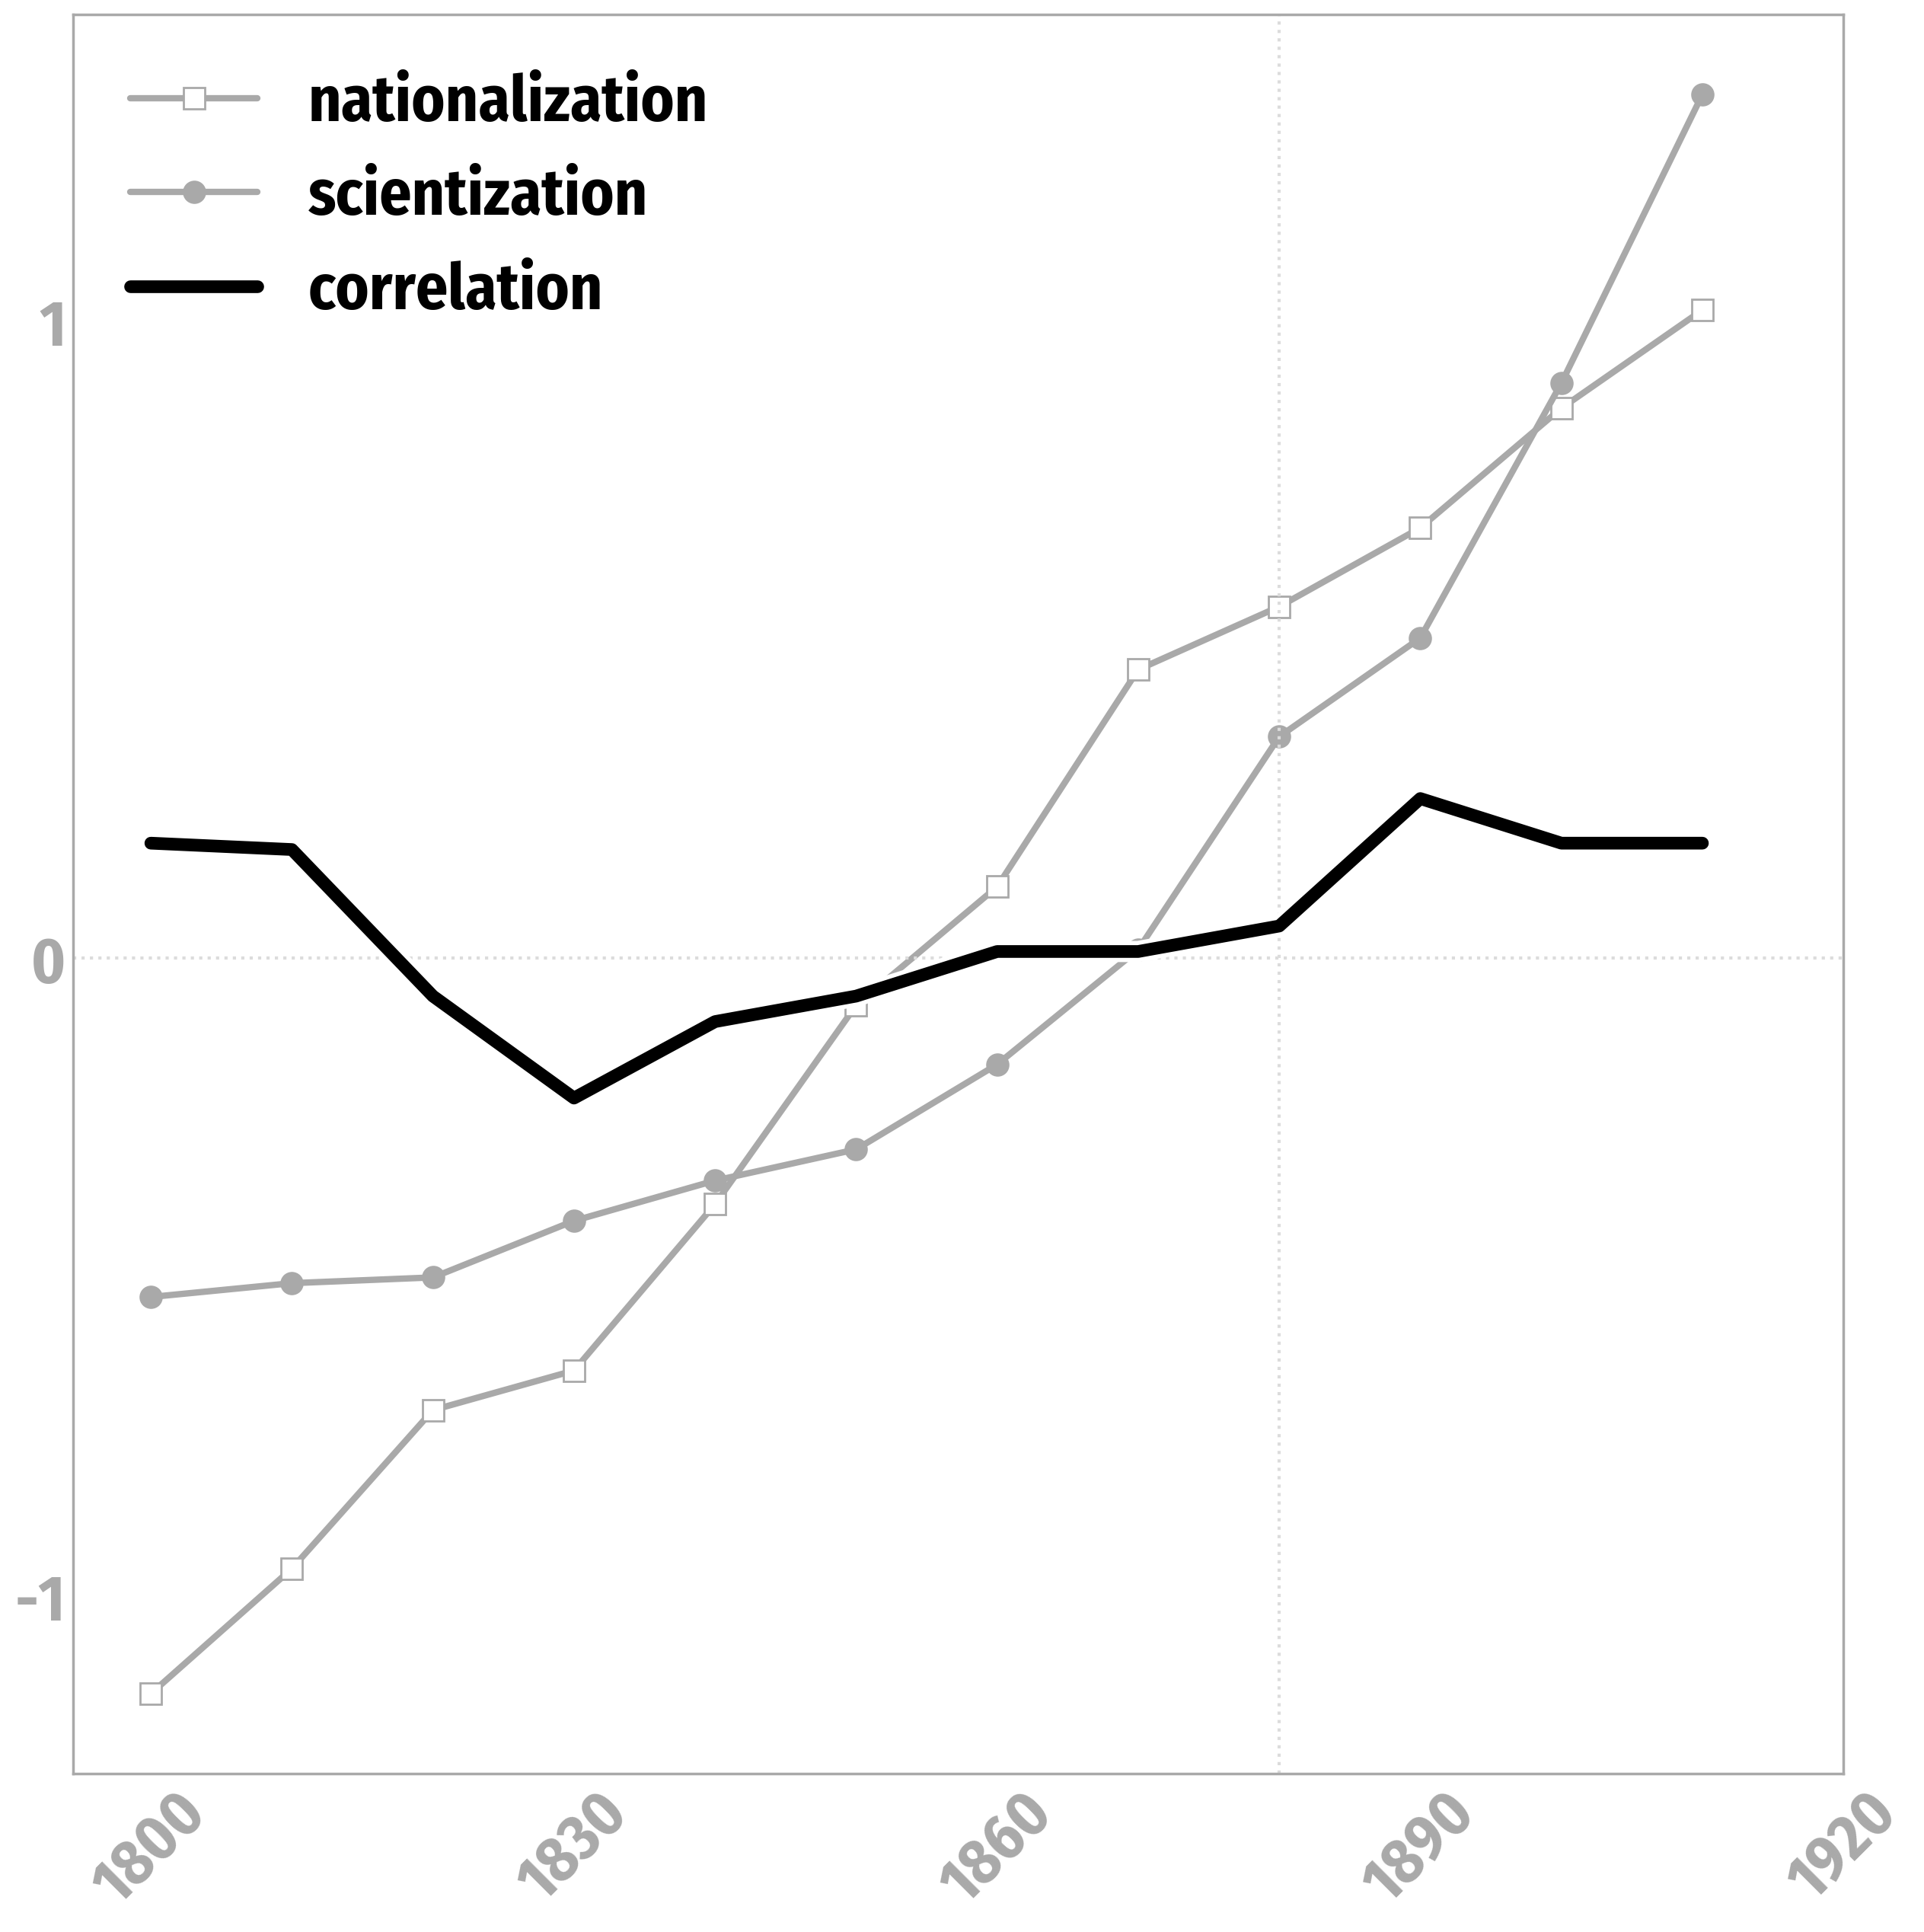

In [751]:
title_color, tick_color, edge_color, data_color = 'black', 'darkgray', 'dimgray', 'whitesmoke'
font_weight = "bold"
font_size = 30
plt.rc('axes', edgecolor='darkgray')
plt.rc('xtick', color='darkgray')
plt.rc('ytick', color='darkgray')
# plt.setp(axs[0].spines.values(), color=tick_color, lw=3);
# plt.setp(axs[1].spines.values(), color=tick_color, lw=3);

fig, ax = plt.subplots()

plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['xtick.labelsize'] = 22
plt.plot(yrs, nat, label='nationalization', color="darkgray", linewidth=3, marker="s", markerfacecolor="white", markersize=10);
plt.plot(yrs, sci, label='scientization', color="darkgray", linewidth=3, marker="o", markersize=10);
plt.axvline(1880, color="gainsboro", linestyle="dotted");
plt.axhline(0, color="gainsboro", linestyle="dotted");
# ax.annotate(f'r > 0 means when states scientized,\nthey also nationalized', 
#             (1820, -.1), 
#             size=16, 
#             c='black', 
#             weight='normal', ha="center")

plt.plot(yrs, 
         cor, 
         label='correlation', 
         color="black",
         linewidth=6,
         path_effects=[pe.Stroke(linewidth=10, foreground='white'), pe.Normal()]);
ax.set_yticks(range(-1,2))
ax.set_yticklabels(range(-1,2), weight=font_weight, fontsize=font_size)
ax.set_xticks(range(1800,1921,30))
ax.set_xticklabels(range(1800,1921,30), rotation=45, weight=font_weight, fontsize=font_size)
plt.legend(labelcolor='black', prop={"weight": "bold", "size": 30});
plt.savefig("figure0.pdf", pad_inches=0, bbox_inches='tight');

In [752]:
variables = ['state', 'year', 'sy_nat_state', 'wy_nat_world', 'sy_sci_state', 'wy_sci_world']
new = ['state', 'year', 'own_nat', 'rest_nat', 'own_sci', 'rest_sci']
# variables = ['state', 'year', 'sy_nat_state', 'sy_sci_state']
# new = ['state', 'year', 'own_nat', 'own_sci' ]
c = dict(zip(variables, new))

In [444]:
west_df[(west_df['state']=='Italy')&(west_df['year'].isin(range(1890,1901)))][variables].rename(columns=c).mean(numeric_only=True).round(4)

year        1895.0000
own_nat        0.5234
rest_nat       1.2113
own_sci        0.5962
rest_sci       1.1463
dtype: float64

In [352]:
west_df[(west_df['state']=='Switzerland')&(west_df['year'].isin([1890,1891,1893]))][variables].rename(columns=c).round(4)

,state,year,own_nat,rest_nat,own_sci,rest_sci
433,Switzerland,1890,1.1770,1.0232,-0.1957,1.0281
434,Switzerland,1891,1.1712,1.0691,1.4334,0.9863
436,Switzerland,1893,1.1598,1.1214,1.4487,1.0585


In [388]:
title_color, tick_color, edge_color, data_color = 'black', 'darkgray', 'dimgray', 'whitesmoke'
font_weight = "bold"
font_size = 22
plt.rc('axes', edgecolor='darkgray')
plt.rc('xtick', color='darkgray')
plt.rc('ytick', color='darkgray')


lim = 3
# year = 1810
for decade in west_df['decade'].unique():
    if decade == 1910: 
        df = west_df[(west_df['year']>decade)]
    elif decade == 1800: 
        df = west_df[(west_df['year']<1810)]
    else: 
        df = west_df[(west_df['year']>=decade) & (west_df['year']<decade+10)]
    df = df.groupby('state').mean()
    
    # colors = cm.brg(np.linspace(0, 1, len(df['sy_nat_state'])))
    colors = sns.color_palette('husl', n_colors=len(df['sy_nat_state']))
    state_colors = {state: color for state, color in zip(df.index, colors)}
    
    
    fig, ax = plt.subplots()
    ax.spines[["left", "bottom"]].set_position(("data", 0))
    ax.spines[["top", "right"]].set_visible(False)
    ax.annotate(f'↑ more\nnationalized', (.05,lim-.25), size=18, c='black', weight='bold')
    ax.annotate(f'more →\nscientized', (lim,-.45), size=18, c='black', weight='bold', ha="right")
    ax.annotate(f'{decade}s', (-lim,lim-.25), size=45, c='black', weight='bold')
    for index, row in df.iterrows():
        ax.scatter(row['sy_sci_state'], row['sy_nat_state'], marker="+", s=50, color=state_colors[index])
    
    # ax.scatter(df['sy_sci_state'], df['sy_nat_state'], marker="+", color=colors)
    # Set x and y axis limits
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_xticks(range(-lim,lim+1), skip=0)
    ax.set_yticks(range(-lim,lim+1))
    ax.set_yticklabels(range(-lim,lim+1), weight=font_weight, fontsize=font_size)
    ax.set_xticklabels(range(-lim,lim+1), weight=font_weight, fontsize=font_size)    
    plt.setp(ax.spines.values(), color=tick_color, lw=3);
    # for index, row in df.iterrows():
    #     ax.annotate(index, (row['sy_sci_state'], row['sy_nat_state']))
    texts = []
    for index, row in df.iterrows():
        text = ax.annotate(index, (row['sy_sci_state'], row['sy_nat_state']), size=18, c=state_colors[index],
                           bbox=dict(facecolor='none', edgecolor='none', pad=0))
        
        text.set_path_effects([pe.Stroke(linewidth=.5, foreground='white'),
                               pe.Normal()])
    
        texts.append(text)
    
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', linewidth=.5), ax=ax)
    fig.savefig(f"{decade}s.jpg", dpi=600, pad_inches=0, bbox_inches='tight')
    break

KeyError: 'decade'

# Descriptive Statistics

## Univariate

In [357]:
west_df[ALL+list(GLOBALS.keys())].agg(['count', 'mean', 'std', 'min', 'max']).T.round(3).to_csv("table1.csv")
west_df['state'].nunique()

20

In [358]:
sorted(west_df['state'].unique())

['Australia',
 'Austria',
 'Belgium',
 'Canada',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Italy',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Poland',
 'Portugal',
 'Spain',
 'Sweden',
 'Switzerland',
 'United Kingdom',
 'United States of America']

In [359]:
print(west_df.groupby('state')['year'].describe()['count'].min())
print(west_df.groupby('state')['year'].describe()['count'].max())
print(west_df.groupby('state')['year'].describe()['count'].mean())

53.0
114.0
99.5


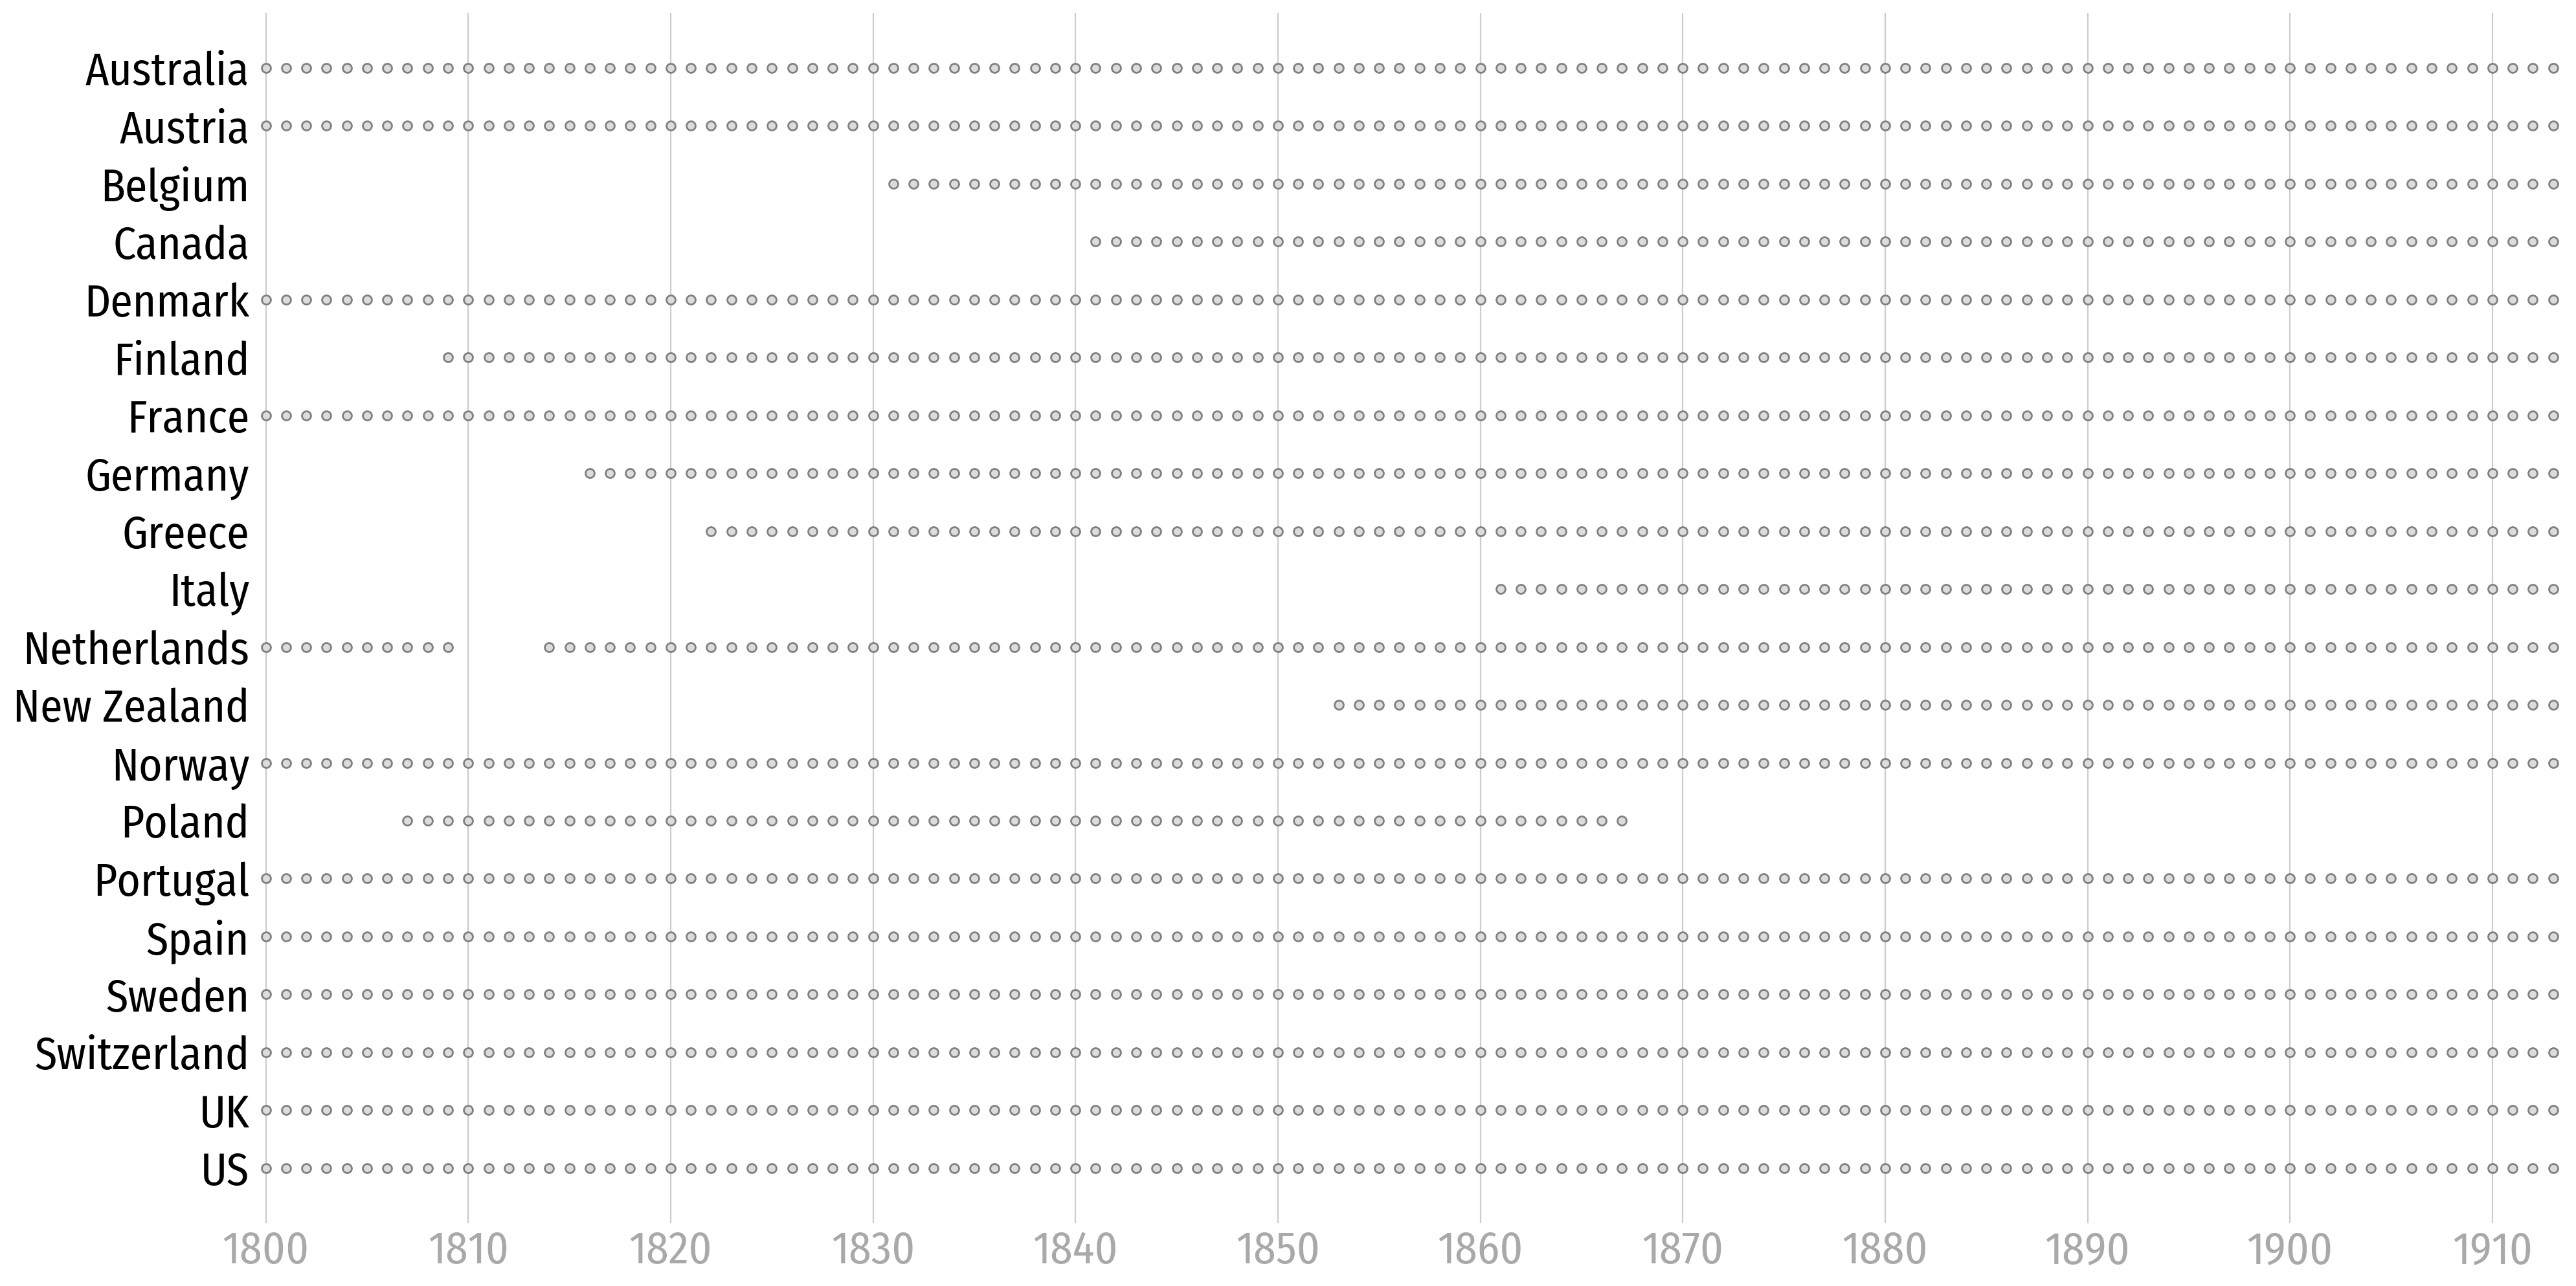

In [386]:
west_df['state'] = np.where(west_df['state'] == 'United States of America', "US", west_df['state'])
west_df['state'] = np.where(west_df['state'] == 'United Kingdom', "UK", west_df['state'])

fig, ax = plt.subplots(figsize=(20,10))

# Removing the spines (the square around the plot region)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


for idx, state in enumerate(sorted(west_df['state'].unique(), reverse=True)):
    # Filtering data for each state
    df_state = west_df[west_df['state'] == state]
    
    # Sorting may be necessary
    df_state = df_state.sort_values(by='year')
    
    # Generating coordinates for lines
    x = df_state['year']
    y = np.repeat(idx, len(x))
    
    # Plot
    ax.plot(x, y, label=state, marker=".", linewidth=0, c='gainsboro', markersize=10, markeredgecolor="gray")

# Setting the y ticks to correspond to states
plt.yticks(range(len(sorted(west_df['state'].unique()))), sorted(west_df['state'].unique(), reverse=True), c="black", size=25)

plt.tight_layout()
min_year = west_df['year'].min()
max_year = west_df['year'].max()
plt.xticks(np.arange(min_year, max_year + 1, 10), size=25)
# Adjusting the x-axis limits to remove padding
ax.set_xlim(left=min_year-.5, right=max_year+.5)
ax.grid(axis="x")
plt.show()

## Bivariate

In [724]:
pd.DataFrame(np.tril(west_df[DEV_STATE+list(GLOBALS.keys())].corr().round(2).to_numpy()), 
             columns=DEV_STATE+list(GLOBALS.keys()),
             index=DEV_STATE+list(GLOBALS.keys()))

,sy_gdp,sy_lifeex,sy_trnsprnt,sy_brcrcy,sy_dev_state,sy_nat_state,sy_sci_state,sy_state_mdl,wy_nat_world,wy_sci_world,wy_state_mdl
sy_gdp,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
sy_lifeex,0.56,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
sy_trnsprnt,0.48,0.47,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
sy_brcrcy,0.45,0.41,0.77,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
sy_dev_state,0.72,0.69,0.91,0.86,1.00,0.00,0.00,0.00,0.00,0.00,0.0
sy_nat_state,0.63,0.50,0.53,0.39,0.62,1.00,0.00,0.00,0.00,0.00,0.0
sy_sci_state,0.44,0.45,0.23,0.13,0.35,0.39,1.00,0.00,0.00,0.00,0.0
sy_state_mdl,0.60,0.57,0.36,0.23,0.50,0.70,0.91,1.00,0.00,0.00,0.0
wy_nat_world,0.63,0.50,0.34,0.29,0.50,0.65,0.53,0.72,1.00,0.00,0.0
wy_sci_world,0.67,0.57,0.35,0.30,0.54,0.65,0.56,0.74,0.97,1.00,0.0


# Standardize Data

In [754]:
analysis_df = west_df.copy()
for col in ALL+list(GLOBALS.keys()): 
    analysis_df["sd_"+col] = zscore(analysis_df[col])
analysis_df['sd_sy_model'] = (analysis_df['sd_sy_nat_state'] + analysis_df['sd_sy_sci_state']) / 2
analysis_df['sd_wy_model'] = (analysis_df['sd_wy_nat_world'] + analysis_df['sd_wy_sci_world']) / 2

In [755]:
napoleon_conquest = {
    "Australia": [],
    "Austria": [1805, 1809, 1810],
    "Belgium": [1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814],
    "Canada": [],
    "Denmark": [],
    "Finland": [1808, 1809],
    "France": [1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815],
    "Germany": [1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813],
    "Greece": [],
    "Hungary": [1809, 1810],
    "Italy": [1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814],
    "Netherlands": [1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813],
    "New Zealand": [],
    "Norway": [],
    "Poland": [1807, 1808, 1809, 1810, 1811, 1812, 1813],
    "Portugal": [],
    "Spain": [1808, 1809, 1810, 1811, 1812, 1813],
    "Sweden": [],
    "Switzerland": [1798, 1799, 1800, 1801, 1802, 1803],
    "UK": [],
    "US": []
}

In [756]:
analysis_df['unoccupied'] = analysis_df.apply(lambda row: 0 if row['year'] in napoleon_conquest.get(row['state'], []) else 1, axis=1)
analysis_df['concertOfEurope'] = np.where(analysis_df['year']<1871, 1, 0)
analysis_df['1870'] = np.where(analysis_df['year']>1870, 0, 1)
analysis_df['1815'] = np.where(analysis_df['year']>1815, 1, 0)
analysis_df['1880'] = np.where(analysis_df['year']>1880, 1, 0)
analysis_df['1848'] = np.where(analysis_df['year']>1848, 1, 0)
analysis_df['sd_sci2'] = analysis_df['sd_sy_sci_state'] * analysis_df['sd_sy_sci_state']
analysis_df['sd_nat2'] = analysis_df['sd_sy_nat_state'] * analysis_df['sd_sy_nat_state']

# Fit Models

## Helper functions 
Since we'll be running 6 models x 3 dvs x 5 robustness checks, or ~90 models, we'll create some helper functions to reduce repeated code.

In [757]:
def nest_models(m0, mn, dv):
    '''
    takes a baseline model;
    returns taxonomy of nested models
    with m3 modifiable
    '''
    m1 = m0 + ['l_sy_war', 'l_sy_riots'] # 1
    ms = [m0, m1] # 2
    ms.append(ms[1] + mn) # 3 modifiable 
    if "model" not in dv:
        ms.append(ms[2] + ['l_wy_nat_world'])
        ms.append(ms[2] + ['l_wy_sci_world'])
    else:
        ms.append(ms[2] + ['l_wy_model'])
    return ms

In [758]:
def gen_model_df(df, models, lag=3):
    '''
    takes a standardized df, a set of regressors, and a lag 
    returns a lagged df with no missingness due to lag
    '''
    
    # New columns names
    COLS = [col for col in df.columns if 'sd_' in col]
    LALL = [col.replace('sd_', 'l_') for col in COLS]
    cmap = dict(zip(COLS, LALL))
    
    # Lag standardized cols
    model_df = df.join(df.sort_values(by=['state','year'])
                       .groupby('state')[COLS]
                       .shift(lag)
                       .rename(columns=cmap), on=df.index)

    # Add dummy for period interactions
    for v  in "l_sy_sci_state l_sy_nat_state l_sy_model".split():
        for p in "1815 1848 1870 1880 unoccupied concertOfEurope".split():
            model_df[f'{p}:{v}'] = model_df[f'{p}'] * model_df[v]        
        
    # Set make state categorical to make it panel var
    state_ids = pd.Categorical(model_df.state)
    model_df = model_df.set_index(["state","year"])
    model_df['state'] = state_ids
    
    # Drop missing
    model_df = model_df.dropna(how='any', subset=[m for m in models][0])
    return model_df

In [759]:
def run_models(dv, models, df):
    '''
    takes a dv, a sequence of models to fit, and a df
    returns results of fitting taxonomy of FE models
    '''
    results = {}
    i = 0
    for model in models: 
        i += 1
        regressors = sm.add_constant(df[model])
        result = PanelOLS(df[dv],
                           regressors,
                           entity_effects=True,
                           check_rank=False).fit(cov_type="clustered",
                                                 cluster_entity=True)
        
        if f'Model {i}' not in results: 
            results[f'Model {i}'] = result
    return results

In [760]:
def _get_vals(result):
    """
    Excerpts values from results object.
    """
    bs = round(result.params, 3).sort_index()
    bs = bs.replace(bs.values, [str(b).replace("0.", ".") for b in bs])
    try: 
        ses = round(result.std_errors, 3).sort_index()
        ses = ses.replace(ses.values, [str(se) for se in ses])
        ses = ses.replace(ses.values, [se.replace("0.", ".") for se in ses])
        ses = ses.replace(ses.values, [f"({se})" for se in ses])
        # ses = round(result[0].std_errors, 3).sort_index()
    except: 
        # ses = round(result[0].HC0_se, 3).sort_index()
        # ses = round(result.std_errors, 3).sort_index()
        # ses = ses.replace(ses.values, [f"({se})" for se in ses])
        ses = ses.replace(ses.values, [str(se) for se in ses])
        ses = ses.replace(ses.values, [se.replace("0.", ".") for se in ses])
        ses = ses.replace(ses.values, [f"({se})" for se in ses])
    ps = round(result.pvalues, 3).sort_index()
    rs_o = round(result.rsquared_overall, 3)
    rs_o = str(rs_o).replace("0.", ".")
    rs_b = round(result.rsquared_between, 3)
    rs_b = str(rs_b).replace("0.", ".")
    rs_w = round(result.rsquared_within, 3)
    rs_w = str(rs_w).replace("0.", ".")
    n_sy = int(result.nobs)
    n_s = int(result.entity_info.total)
    n_y = int(result.time_info.total)
    info = pd.Series([rs_o, rs_b, rs_o, n_sy, n_s, n_y], index=["R-squared (overall)", 
                                                                "R-squared (between)", 
                                                                "R-squared (within)", 
                                                                "N state-years",
                                                                "N states", 
                                                                "N years"])
    return bs, ses, ps, info


def _add_stars(bs, ps):
    """
    Adds significance starts to parameters.
    """
    for i, p in ps.items(): 
        if p < .001:
            bs[i] = f"{bs[i]}***"
        elif p < .01 and p > .001:
            bs[i] = f"{bs[i]}**"
        elif p < .05 and p > .01:
            bs[i] = f"{bs[i]}*"
        elif p < .1 and p > .05:
            bs[i] = f"{bs[i]}+"
    return bs


def _make_df(bs, ses, info, name):
    """
    Concatenates all model vals into one data frame.
    """
    df = pd.DataFrame(pd.DataFrame(pd.concat([bs,ses], axis=1)).stack())
    df = pd.concat([info, df])
    df = df.rename(columns={0: name})
    return df


def write_table(results_dct, dir, table_n):
    """
    Writes a csv.
    """
    dfs = []
    for name, result in results_dct.items():
        bs, ses, ps, info = _get_vals(result)
        bs = _add_stars(bs, ps)
        df = _make_df(bs, ses, info, name)
        dfs.append(df)  
    print(f"{dir}table_{table_n}.xlsx")
    pd.concat(dfs, axis=1).to_excel(f"{dir}table_{table_n}.xlsx", 
                        index=True, 
                        engine='xlsxwriter', 
                        sheet_name=f'table_{table_n}')

## Run models

In [784]:
review_keywords = {
    "ACCURACY": ["inaccurate", "flawed", "unsound", "unsupported", "bias", "miscalculated", "erroneous", "false", "invalid", "misleading",
                 "accurate", "precise", "valid", "sound", "supported", "correct", "true", "justified", "verifiable", "convincing"],
    "THOROUGHNESS": ["incomplete", "superficial", "fragmented", "rushed", "narrow", "shallow", "perfunctory", "sparse", "lacking", "meager",
                     "comprehensive", "detailed", "complete", "thorough", "extensive", "rigorous", "deep", "broad", "elaborate", "substantial"],
    "CONSISTENCY": ["inconsistent", "contradictory", "conflicting", "unreliable", "misaligned", "disparate", "erratic", "varying", "unstable", "divergent",
                    "consistent", "harmonious", "aligned", "reliable", "steady", "uniform", "coherent", "stable", "congruent", "compatible"],
    "NOVELTY": ["trivial", "obsolete", "derivative", "outdated", "banal", "commonplace", "mundane", "stale", "imitative", "familiar",
                "novel", "innovative", "original", "unique", "groundbreaking", "revolutionary", "unprecedented", "pioneering", "cutting-edge", "inventive"],
    "CLARITY": ["ambiguous", "vague", "confusing", "obscure", "incoherent", "unclear", "cryptic", "muddled", "convoluted", "opaque",
                "clear", "coherent", "lucid", "explicit", "distinct", "intelligible", "comprehensible", "well-defined", "transparent", "crisp"],
    "REPLICABILITY": ["unrepeatable", "irreproducible", "unverifiable", "inaccessible", "opaque", "closed", "confused", "inconsistent", "undocumented", "obscure",
                      "replicable", "reproducible", "verifiable", "accessible", "transparent", "open", "consistent", "documented", "clear", "detailed"]
}

In [785]:
for k, v in review_keywords.items():
    print(k)
    for w in v: 
        print(w)
    print()

ACCURACY
inaccurate
flawed
unsound
unsupported
bias
miscalculated
erroneous
false
invalid
misleading
accurate
precise
valid
sound
supported
correct
true
justified
verifiable
convincing

THOROUGHNESS
incomplete
superficial
fragmented
rushed
narrow
shallow
perfunctory
sparse
lacking
meager
comprehensive
detailed
complete
thorough
extensive
rigorous
deep
broad
elaborate
substantial

CONSISTENCY
inconsistent
contradictory
conflicting
unreliable
misaligned
disparate
erratic
varying
unstable
divergent
consistent
harmonious
aligned
reliable
steady
uniform
coherent
stable
congruent
compatible

NOVELTY
trivial
obsolete
derivative
outdated
banal
commonplace
mundane
stale
imitative
familiar
novel
innovative
original
unique
groundbreaking
revolutionary
unprecedented
pioneering
cutting-edge
inventive

CLARITY
ambiguous
vague
confusing
obscure
incoherent
unclear
cryptic
muddled
convoluted
opaque
clear
coherent
lucid
explicit
distinct
intelligible
comprehensible
well-defined
transparent
crisp

REPLIC

### Tables 2, 3, 4 & Appendix B
Main report results and robustness checks for lag period

In [761]:
dvs = ['sd_sy_nat_state', 
       'sd_sy_sci_state', 
       'sd_sy_model',
       # 'sd_sy_state_mdl',
      ]

lags = [10,7,3]
tbl = 1
tblb = 0
for lag in lags:
    for dv in dvs:
        ldv = dv.replace("sd_", "l_")
        m0 = ["l_" + var for var in GLOBALS['sy_dev_state']]
        m0.append(f"{ldv}")
        # nest models & gen lagged df
        # nested m3 depends on dv
        p = "1848"
        if 'nat' in dv: 
            # m3 = ['l_sy_sci_state', f'{p}', f'{p}:l_sy_sci_state'] 
            # m3 = ['l_sy_sci_state', 'l_sci2']
            m3 = ['l_sy_sci_state'] 
        elif 'sci' in dv:
            # m3 = ['l_sy_nat_state', f'{p}', f'{p}:l_sy_nat_state'] 
            # m3 = ['l_sy_nat_state', 'l_nat2']
            m3 = ['l_sy_nat_state']
        else:
            pass
        
        ms = nest_models(m0, m3, dv)
        # df = gen_model_df(df=states_df, lag=lag, models=ms)
        # df = gen_model_df(df=napoleon_states, lag=lag, models=ms)
        df = gen_model_df(df=analysis_df, lag=lag, models=ms)
        
        # Run model & output results
        results = run_models(dv, ms, df)

        # robustness checks
        if lag != 10:
            tblb += 1
            write_table(results_dct=results,
                        dir = DIR+"/models/",
                        table_n=f'b{tblb}-{lag}')
            
        # main results
        else: 
            tbl += 1
            write_table(results_dct=results,
                        dir = DIR+"/models/",
                        table_n=tbl)      
    
        # # robustness checks
        # if lag != 10:
        #     tblb += 1
        #     write_table(path = DIR+"/models/",
        #                results=results,
        #                table_n=f'b{tblb}-{lag}')
            
        # # main results
        # else: 
        #     tbl += 1
        #     write_table(path = DIR+"/models/", 
        #                results=results,
        #                table_n=tbl)

/Users/otto/Library/CloudStorage/GoogleDrive-danielscottsmith@gmail.com/My Drive/00_Researching/00_scientization/19cStates//models/table_2.xlsx
/Users/otto/Library/CloudStorage/GoogleDrive-danielscottsmith@gmail.com/My Drive/00_Researching/00_scientization/19cStates//models/table_3.xlsx
/Users/otto/Library/CloudStorage/GoogleDrive-danielscottsmith@gmail.com/My Drive/00_Researching/00_scientization/19cStates//models/table_4.xlsx
/Users/otto/Library/CloudStorage/GoogleDrive-danielscottsmith@gmail.com/My Drive/00_Researching/00_scientization/19cStates//models/table_b1-7.xlsx
/Users/otto/Library/CloudStorage/GoogleDrive-danielscottsmith@gmail.com/My Drive/00_Researching/00_scientization/19cStates//models/table_b2-7.xlsx
/Users/otto/Library/CloudStorage/GoogleDrive-danielscottsmith@gmail.com/My Drive/00_Researching/00_scientization/19cStates//models/table_b3-7.xlsx
/Users/otto/Library/CloudStorage/GoogleDrive-danielscottsmith@gmail.com/My Drive/00_Researching/00_scientization/19cStates//mod

In [361]:
analysis_df.to_csv(DATA + "processed/" + "pro_19cStates.csv", index=False)

### Appendix C
Modeling development as an integrated historical phenom

In [ ]:
dvs = ['sy_nat_state', 'sy_sci_state', 'sy_state_mdl']
m0 = ['l_sy_dev_state']
j = 0
for dv in dvs: 
    j += 1
    if 'mdl' not in dv: 
        m3 = ['l_sy_nat_state', 'l_sy_sci_state'] 
    else:
        m3 = ['l_sy_state_mdl'] 
    ms = nest_models(m0, m3)
    df = gen_model_df(df=states_df, lag=lag, models=ms)
    results = run_models(dv, ms, df)
    write_table(path = DIR+"/models/",
               results=results, 
               table_n=f'c{j}')

### Appendix D
Testing whether nationalization depends on scientizaiton

In [ ]:
dvs = ['sy_nat_state', 'sy_sci_state']
m0 = ['l_sy_suffrage', 'l_sy_xtr_urban','l_sy_gdp']

j = 0
for dv in dvs: 
    j += 1
    m3 = ['l_sy_nat_state', 'l_sy_sci_state', 'l_sci:nat']
    ms = nest_models(m0, m3)
    df = gen_model_df(df=states_df, lag=lag, models=ms)
    results = run_models(dv, ms, df)
    write_table(path = DIR+"/models/",
               results=results, 
               table_n=f'd{j}')

# Output processed data
This will be used for visualizations

In [ ]:
states_df.to_csv(DATA+'processed/pro_19cStates.csv', index=False)

In [ ]:
states_df.shape